# Ch 19: The Goodies: Syntax

### Named Tuples

In [1]:
x = (a=1, b=1+1)
x.a

1

### Functions: compact syntax and anonymous functions

In [2]:
f(x,y) = x + y

f (generic function with 1 method)

In [3]:
x -> x^2 + 2x - 1

#3 (generic function with 1 method)

In [4]:
function (x)
    x^2 + 2x - 1
end

#5 (generic function with 1 method)

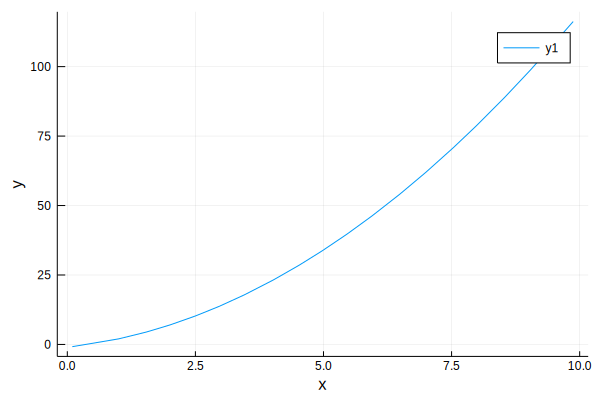

In [5]:
using Plots
plot(x -> x^2 + 2x - 1, 0, 10, xlabel="x", ylabel="y")

### Keyword Arguments

Keyword arguments in a function are specified after a semicolon in the signature but can be called with a comma.

In [6]:
function myplot(x, y; style="solid", width=1, color="black")
    ###
end

myplot (generic function with 1 method)

### Closures

A closure is a technique allowing a function to capture a variable defined outside the calling scope of the function.

In [7]:
foo(x) = ()->x
bar = foo(1)
bar()

1

### Blocks

A block is a way to group a number of statements. A block starts with the keyword `begin` and ends with `end`.

#### `let` blocks

A let block is useful to create new bindings, i.e. locations that can refer to values.

In [8]:
x, y, z = -1, -1, -1;
let x = 1, z
    @show x y z;
end

x = 1
y = -1


UndefVarError: UndefVarError: z not defined

In [9]:
@show x y z;

x = -1
y = -1
z = -1


In the example, the first @show macro, shows the local x , the global y and the undefined local z . The global variables are untouched.


#### do Blocks

In Reading and Writing we had to close the file after when where done writing. This can be done automatically using a do block:

In [10]:
data = "This here's the wattle,\nthe emblem of our land.\n"

open("testoutput.txt", "w") do fout
    write(fout, data)
end

48

This is functionally equivalent to

In [13]:
f2 = fout -> begin
    write(fout, data)
end

open(f2, "output.txt", "w")


# in Base.open
#
# function open(f::Function, args...)
#     io = open(args...)
#     try
#         f(io)
#     finally
#         close(io)
#     end
# end

48

A do block can “capture” variables from its enclosing scope. For example, the variable data in the above example of open ... do is captured from the outer scope.

### Control Flow

#### Ternary Operator

The ternary operator, ?: , is an alternative to an if-elseif statement used when you need to make a choice between single expression values.

In [14]:
a = 150

a % 2 == 0 ? println("even") : println("odd")

even


#### Short-Circuit Evaluation

The operators && and || do a short-circuit evaluation: a next argument is only evaluated when it is needed to determine the final value.

For example, a recursive factorial routine could be defined like this:

In [26]:
function fact(n::Integer)
    n >= 0 || error("n must be non-negative")  # the second statement is called only if the first (n>=0) is false
    n == 0 && return 1 # the second statement is called only if the first (n==0) is true.  Same as if n == 0 then return 1 end
    n * fact(n-1)
end

fact (generic function with 1 method)

#### Tasks (aka Coroutines)

A task is a control structure that can pass cooperatively control without returning. In Julia, a task can be implemented as a function having as first argument a Channel object. A channel is used to pass values from the function to the callee.

In [24]:
function fib(c::Channel)
    
    a = 0
    b = 1
    put!(c, a)
    
    while true
        put!(c, b)
        (a, b) = (b, a+b)
    end
    
end

fib (generic function with 1 method)

`put!` stores values in a channel object and `take!` reads values from it:

In [17]:
fib_gen = Channel(fib);

In [18]:
take!(fib_gen)

0

In [19]:
take!(fib_gen)

1

In [20]:
take!(fib_gen)

1

In [21]:
take!(fib_gen)

2

In [22]:
take!(fib_gen)

3

In [23]:
take!(fib_gen)

5

The constructor `Channel` creates the task. The function `fib` is suspended after each call to `put`! and resumed after `take!`. For performance reasons, several values of the sequence are buffered in the channel object during a resume/suspend cycle.

A channel object can also be used as an iterator:

In [25]:
for val in Channel(fib)
    print(val, " ")
    val > 20 && break
end

0 1 1 2 3 5 8 13 21 

### Types

#### Primitive Types

A concrete type consisting of plain old bits is called a primitive type. Unlike most languages, with Julia you can declare your own primitive types. The standard primitive types are defined in the same way:

In [27]:
#primitive type Float64 <: AbstractFloat 64 end
#primitive type Bool <: Integer 8 end
#primitive type Char <: AbstractChar 32 end
#primitive type Int64 <: Signed 64 end

The number in the statements specifies how many bits are required.

The following example creates a primitive type Byte and a constructor:

In [28]:
primitive type Byte 8 end
Byte(val::UInt8) = reinterpret(Byte, val)
b = Byte(0x01)

Byte(0x01)

#### Parametric Types

Julia’s type system is parametric, meaning that types can have parameters.

Type parameters are introduced after the name of the type, surrounded by curly braces:

In [5]:
struct Point{T<:Real}
    x::T
    y::T
end

This defines a new parametric type, `Point{T<:Real}`, holding two "coordinates" of type `T`, which can be any type having
`Real` as supertype.

In [6]:
Point(0.0, 0.0)

Point{Float64}(0.0, 0.0)

In addition to composite types, abstract types and primitive types can also have a type parameter.
    
TIP:  Having concrete types for struct fields is absolutely recommended for performance reasons, so this is a good way to make `Point` both fast and flexible.

#### Type Unions

A type union is an abstract parametric type that can act as any of its argument types.  A type union is in most computer language an internal construct for reasoning about types. Julia however exposes this feature to its users because efficient code can be generated when the type union has a small number of types. This feature gives the Julia programmer a tremendous flexibility for controlling dispatch.

In [1]:
IntOrString = Union{Int64, String}

Union{Int64, String}

In [2]:
150 :: IntOrString

150

In [3]:
"Julia" :: IntOrString

"Julia"

### Methods

#### Parametric Methods

Method definitions can also have type parameters qualifying their signature:

In [7]:
isintpoint(p::Point{T}) where {T} = (T === Int64)

p = Point(1, 2)
isintpoint(p)

true

#### Function-like Objects

Any arbitrary Julia object can be made “callable”. Such “callable” objects are sometimes called functors.

In [8]:
struct Polynomial{R}
    coeff::Vector{R}
end

function (p::Polynomial)(x)
    val = p.coeff[end]
    for coeff in p.coeff[end-1:-1:1]
    val = val * x + coeff
    end
    val
end

In [9]:
p = Polynomial([1,10,100])

Polynomial{Int64}([1, 10, 100])

In [10]:
p(3)

931

### Constructors

Parametric types can be explicitly or implicitly constructed:

In [13]:
Point(1,2) # implicit T

Point{Int64}(1, 2)

In [15]:
Point{Int64}(1, 2) # explicit T

Point{Int64}(1, 2)

In [16]:
Point(1,2.5)

MethodError: MethodError: no method matching Point(::Int64, ::Float64)
Closest candidates are:
  Point(::T<:Real, !Matched::T<:Real) where T<:Real at In[5]:2

Default inner and outer constructors are generated for each T:

```
struct Point{T<:Real}
    x::T
    y::T
    Point{T}(x,y) where {T<:Real} = new(x,y)
end

Point(x::T, y::T) where {T<:Real} = Point{T}(x,y);
```

and both x and y have to be of the same type.

When x and y have a different type, the following outer constructor can be defined:

In [17]:
Point(x::Real, y::Real) = Point(promote(x,y)...);

### Conversion and Promotion

Julia has a system for promoting arguments to a common type. This is not done automatically but can be easily extended. 

#### Conversion

A value can be converted from one type to another:

In [18]:
x = 12

typeof(x)

Int64

In [21]:
answer = convert(UInt8, x)

typeof(answer)

UInt8

We can add our own convert methods:

In [22]:
Base.convert(::Type{Point{T}}, x::Array{T, 1}) where {T<:Real} = Point(x...)

In [23]:
convert(Point{Int64}, [1, 2])

Point{Int64}(1, 2)

#### Promotion

Promotion is the conversion of values of mixed types to a single common type:

In [24]:
promote(1, 2.5, 3)

(1.0, 2.5, 3.0)

Methods for the promote function are normally not directly defined, but the auxiliary function promote_rule is used to
specify the rules for promotion:

In [25]:
promote_rule(::Type{Float64}, ::Type{Int32}) = Float64

promote_rule (generic function with 1 method)

### Metaprogramming

Julia code can be represented as a data structure of the language itself. This allows a program to transform and generate its own code.

#### Expressions

Every Julia program starts as a string:

In [26]:
prog = "1 + 2"

ex = Meta.parse(prog)
typeof(ex)

Expr

In [27]:
dump(ex)

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol +
    2: Int64 1
    3: Int64 2


The dump function displays expr objects with annotations.

Expressions can be constructed directly by prefixing with : inside parentheses or using a `quote` block

In [28]:
ex = quote
    1 + 2
end;

Julia can evaluate an expression object using `eval`:

In [29]:
eval(ex)

3

Every module has its own `eval` function that evaluates expressions in its scope.

WARNING

When you are using a lot of calls to the function `eval`, often this means that something is wrong. `eval` is considered “evil”.

### Macros

Macros can include generated code in a program. A macro maps a tuple of Expr objects directly to a compiled expression:

Here is a simple macro:

In [30]:
macro containervariable(container, element)
    return esc(:($(Symbol(container,element)) = $container[$element]))
end

@containervariable (macro with 1 method)

Macros are called by prefixing their name with the @ (at-sign). The macro call @containervariable letters 1 is
replaced by:

```
:(letters1 = letters[1])
```

In [31]:
@macroexpand @containervariable letters 1

:(letters1 = letters[1])

This example illustrates how a macro can access the name of its arguments, something a function can’t do. The return expression needs to be “escaped” with esc because it has to be resolved in the macro call environment.

NOTE: Why macros?

Macros are necessary because they execute when code is parsed, therefore, macros allow the programmer to generate and include fragments of customized code before the full program is run. 

#### Generated Functions

A very special macro is @generated, which allows you to define so-called generated functions. These have the capability to generate specialized code depending on the types of their arguments with more flexibility and/or less code than what can be achieved with multiple dispatch.

In [11]:
@generated function square_gen(x)
    Core.println(x)
    :(x * x)
end

square_gen (generic function with 1 method)

The body returns a quoted expression like a macro.

For the caller, the generated function behaves as a regular function:

In [12]:
x = square_gen(2);

Int64


In [13]:
x

4

In [14]:
y = square_gen("bar");

String


In [15]:
y

"barbar"

### Missing Values

Missing values can be represented via the missing object, which is the singleton instance of the type `Missing`. Arrays can contain missing values:

In [3]:
a = [1, missing]

2-element Array{Union{Missing, Int64},1}:
 1       
  missing

The element type of such an array is `Union{Missing, T}`, with `T` the type of the non-missing values.

Reduction functions return missing when called on arrays which contain missing values

In [4]:
sum(a)

missing

In this situation, use the skipmissing` function to skip missing values:

In [5]:
sum(skipmissing([1, missing]))

1

### Calling C and Fortran Code

A lot of code is written in C or Fortran. Reusing tested code is often better than writing your own version of an algorithm.

Julia can call directly existing C or Fortran libraries using the ccall syntax.
A Julia interface exists for  the GDBM library of database functions. The library is written in C. To close the database a function call to close(db) has to be made:

```
Base.close(dbm::DBM) = gdbm_close(dbm.handle)
function gdbm_close(handle::Ptr{Cvoid})
    ccall((:gdbm_close, "libgdbm"), Cvoid, (Ptr{Cvoid},), handle)
end
```

A dbm object has a field handle of Ptr{Cvoid} type. This field holds a C pointer that refers to the database. 

To close the database the C function `gdbm_close` has to be called having as only argument the C pointer pointing to the database and no return value. 

Julia does this directly with the ccall function having as arguments:

* a tuple consisting of a symbol holding the name of the function we want to call: `:gdbm_close` and the shared library specified as a string: `"libgdm"`,
* the return type: `Cvoid`,
* a tuple of argument types: (Ptr{Cvoid},) and the argument values: `handle`.